In [1]:
import numpy as np
from astropy.io import fits
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.ndimage import zoom
from importlib import reload
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import NMF

import sys
sys.path.append('/home/plcristille/dev/utils')
import plot
from plot import load_dataset_SYNTHETIC_NOISY, load_unmixed_dataset_SYNTHETIC, plot_sampled_images, plot_spec, norm_hypercube
from plot import return_mixture, noise_data_for_snr, add_poisson_noise, unmix
sys.path.append('/home/plcristille/dev/JWST/fusion_inverse/MS-HS-Fusion-Study-Case')
import instrument_models
from instrument_models import *
from criteria_definitions import *
import plot_tools
import noise_data
from reco_quality_metrics import *


sys.path.append('/home/plcristille/dev/JWST/Instrument_func/')
import functions_for_fusion_end_to_end
from functions_for_fusion_end_to_end import Mirim_Model_Cube, Spectro_Model_Cube, Mirim_Model_Cube_for_Tensors
from functions_for_fusion_end_to_end import Spectro_Model_Cube_for_Tensors, maps_to_cube, np_to_var, min_not_zero, rescale_0_1, var_to_np


In [2]:
wavelength_NIRSpec = np.load("/home/plcristille/dev/JWST/NIRCam_NIRSpec/NIRSpec_wave.npy")[::10]
NIRCam_pce = np.load("/home/plcristille/dev/JWST/NIRCam_NIRSpec/PCE/NIRCam/NIRCam_PCE.npy")[:,::10]
NIRCam_PSF = np.load("/home/plcristille/dev/Webb_PSF/Saved_PSFs/instNIRCam_psfs_pixscale0.15000000000000002_fov6.000000000000001_nb28.npy")
NIRSpec_PSF = np.load("/home/plcristille/dev/Webb_PSF/Saved_PSFs/instNIRSpec_psfs_pixscale0.15000000000000002_fov6.000000000000001_nb1106.npy")[::10,:,:]
L_pce_NIRSpec = np.load("/home/plcristille/dev/JWST/NIRCam_NIRSpec/PCE/NIRSpec/NIRSpec_PCE.npy")[::10]
spec_database = np.load("/home/plcristille/dev/JWST/NIRCam_NIRSpec/NIRSpec_spectra/spectra_dataset.npy")
mixture_specs = spec_database[np.random.choice(range(spec_database.shape[0]), 5, replace=False)]
size = (40,40)
di, dj = 2, 2
margin = 8


x_old = np.linspace(0, 1, mixture_specs.shape[1])
x_new = np.linspace(0, 1, L_pce_NIRSpec.shape[0])

interp_func = interp1d(x_old, mixture_specs, kind='linear', axis=1, fill_value="extrapolate")
mixture_specs = interp_func(x_new)

mixture_specs = norm_hypercube(mixture_specs, min_value=0,max_value=600)


spat_ss = 2

fname_true_maps = "/home/plcristille/dev/JWST/Instrument_func/Abundance_maps_NEW.fits"
fits_cube = fits.open(fname_true_maps)
true_maps = np.asarray(fits_cube[0].data, dtype=np.float32)[:, ::spat_ss, :: spat_ss]
true_maps.shape

# MODIFYING ABUNDANCE MAP 1

true_maps[0][true_maps[0] > 0.8] = 0.8

# MODIFYING ABUNDANCE MAP 4

n_map = 3

map4 = true_maps[n_map]
# plt.imshow(map4)

d = 20
i1, j1 = 104, 202
# star1 = map4[i1 - d : i1 + d, j1 - d : j1 + d]
i2, j2 = 121, 318
# star2 = map4[i2 - d : i2 + d, j2 - d : j2 + d]
i3, j3 = 113, 345
# star3 = map4[i3 - d : i3 + d, j3 - d : j3 + d]
# star3.shape

mask = np.zeros((2 * d, 2 * d))
mask.shape

# plt.imshow(star3)

map4[i1 - d : i1 + d, j1 - d : j1 + d] = mask
map4[i2 - d : i2 + d, j2 - d : j2 + d] = mask
map4[i3 - d : i3 + d, j3 - d : j3 + d] = mask

# plt.imshow(map4)


# changing values of map 4
map4[map4 <= 0.35] = 0
min_not_zero_map_4 = min_not_zero(map4)
map4[map4 == 0] = min_not_zero_map_4
map4_rescaled = rescale_0_1(map4)

map4_rescaled_blurred = gaussian_filter(map4_rescaled, 1.4)

map4_rerescaled = rescale_0_1(map4_rescaled_blurred)

true_maps[n_map] = map4_rerescaled



# IF SUBSAMPLING
true_maps = true_maps[:, ::2, ::2]
rect_ld = (152,40,size[0],size[1])

# ELSE
# rect_ld = (310,100,size[0],size[1])

true_maps = true_maps[:, rect_ld[1]:rect_ld[1]+size[1], rect_ld[0]:rect_ld[0]+size[0]]
shape_target = true_maps.shape[1:]

GT = return_mixture(mixture_specs, true_maps.T)
# maps, L_specs, scaler = unmix(GT, scaler=None, alpha_W=1e-3, alpha_H='same', l1_ratio=0.0)

maps, L_specs = true_maps, mixture_specs

In [ ]:
def make_H_spec_freq_sum2_pceInvert(array_psfs, L_lamb, L_spec, shape_target, di, dj, pixel_arcsec = 0.111):
    # print("Use of function {}.".format("make_H_spec_freq_sum"))
    # weighted_psfs = array_psfs * L_pce[..., np.newaxis, np.newaxis] # (300, 250, 500)
    newaxis_weighted_psfs = array_psfs[np.newaxis, ...] # (1, 300, 250, 500)
    
    # L_spec = unit_conversion(L_spec, L_lamb * 1e-6, pixel_arcsec)
    specs = L_spec[..., np.newaxis, np.newaxis] # (5, 300, 1, 1)

    H_spec = newaxis_weighted_psfs * specs # (5, 300, 250, 500)

    H_spec_freq = ir2fr(H_spec, shape_target)
    
    # différence par rapport à make_H_spec_freq est ici
    kernel_for_sum = np.ones((di, dj)) # le flux est bien intégré sur toute la surface du pixel, sans normalisation
    # print("avant ir2fr de make_H_spec_freq")
    kernel_for_sum_freq = ir2fr(kernel_for_sum, shape_target)[np.newaxis, np.newaxis, ...] # (1, 1, 250, 251)
    # print("après ir2fr de make_H_spec_freq")
    
    return H_spec_freq * kernel_for_sum_freq # (5, 300, 250, 251)

def make_H_spec_freq_sum2(array_psfs, L_pce, L_lamb, L_spec, shape_target, di, dj, pixel_arcsec = 0.111):
    # print("Use of function {}.".format("make_H_spec_freq_sum"))
    weighted_psfs = array_psfs * L_pce[..., np.newaxis, np.newaxis] # (300, 250, 500)
    newaxis_weighted_psfs = weighted_psfs[np.newaxis, ...] # (1, 300, 250, 500)
    
    # L_spec = unit_conversion(L_spec, L_lamb * 1e-6, pixel_arcsec)
    specs = L_spec[..., np.newaxis, np.newaxis] # (5, 300, 1, 1)

    H_spec = newaxis_weighted_psfs * specs # (5, 300, 250, 500)

    H_spec_freq = ir2fr(H_spec, shape_target)
    
    # différence par rapport à make_H_spec_freq est ici
    kernel_for_sum = np.ones((di, dj)) # le flux est bien intégré sur toute la surface du pixel, sans normalisation
    # print("avant ir2fr de make_H_spec_freq")
    kernel_for_sum_freq = ir2fr(kernel_for_sum, shape_target)[np.newaxis, np.newaxis, ...] # (1, 1, 250, 251)
    # print("après ir2fr de make_H_spec_freq")
    
    return H_spec_freq * kernel_for_sum_freq # (5, 300, 250, 251)

class Initial_Spectrometer_model(LinOp):
    def __init__(
        self, psfs_monoch, L_pce, di:int, dj:int, lamb_cube, L_specs, shape_target, old_model=False, pixel_arcsec=0.111 # size of pixels before integration and decimation of spectro
    ):
        assert shape_target[0] % di == 0
        assert shape_target[1] % dj == 0
        
        assert psfs_monoch.shape[1] <= shape_target[0] # otherwise ir2fr impossible
        assert psfs_monoch.shape[2] <= shape_target[1]
        
        self.old_model = old_model

        kernel_for_sum = np.ones((di, dj)) # le flux est bien intégré sur toute la surface du pixel, sans normalisation
        kernel_for_sum_freq = ir2fr(kernel_for_sum, shape_target, real=False)[np.newaxis, ...] # (1, 250, 500)
    
        self.psfs_freq = ir2fr(
            psfs_monoch * L_pce[:, np.newaxis, np.newaxis],
            shape=shape_target,
            real=False,
        ) * kernel_for_sum_freq
        
        # # translation dans Fourier pour sauvegarde de la convolution en haut à gauche
        # # MÉTHODE 1
        decal = np.zeros(shape_target)
        dsi = int((di-1)/2)
        dsj = int((dj-1)/2)
        # if ds != 0:
        #     ds = 0
        # print("dsi", dsi, "dsj", dsj)
        decal[- dsi, - dsj] = np.sqrt(shape_target[0] * shape_target[1]) # surement pour annuler les normalisations qui arrivent dans le passage de Fourier ?
        decalf = dft2(decal)

        h_block, w_block = int(shape_target[0] / di), int(shape_target[1] / dj)
        
        # partitionnement
        # part_psfs_freq_full = partitioning_einops2(psfs_freq, di, dj)
        part_psfs_freq_full = partitioning_einops2(self.psfs_freq * decalf, di, dj)
        # print("part_psfs_freq_full", part_psfs_freq_full.shape)

        # conjugué des psfs partitionnées
        conj_part_psfs_freq_full = np.conj(part_psfs_freq_full)
        # print("conj_part_psfs_freq_full", conj_part_psfs_freq_full.shape)

        # produit des psfs avec les conjuguées
        # (300, 1, 25, 50, 100) * (300, 25, 1, 50, 100) = (300, 25, 25, 50, 100)
        mat = (
            (1 / (di * dj))
            * part_psfs_freq_full[:, np.newaxis, ...]
            * conj_part_psfs_freq_full[:, :, np.newaxis, ...]
        )
        # print("mat", mat.shape)

        # création de HtH
        L_specs_converted = unit_conversion(L_specs, lamb_cube * 1e-6, pixel_arcsec)
        specs = L_specs_converted[
            :, :, np.newaxis, np.newaxis, np.newaxis, np.newaxis
        ]  # (5, 300, 1, 1)
        # print("check1")
        n_spec = specs.shape[0]
        HtH_freq = np.zeros(
            (n_spec, n_spec, di * dj, di * dj, h_block, w_block), dtype=complex
        )
        # print("check2")
        for k1 in range(n_spec):
            for k2 in range(k1, n_spec):
                HtH_freq[k1, k2] += np.sum(specs[k1] * specs[k2] * mat, axis=0)

        # print("check3")
        # utilisation de la symétrie de HtH
        for k1 in range(n_spec):
            for k2 in range(k1):
                HtH_freq[k1, k2] += HtH_freq[k2, k1]

        self.hess_spec_freq = HtH_freq

        # H_spec_freq utile pour forward et adjoint
        # self.H_spec_freq = make_H_spec_freq_sum2(
        #     psfs_monoch, L_pce, lamb_cube, L_specs, shape_target, di, dj
        # )
        
        # print("2 x H_spec_freq enlevés !!")
        
        self.H_spec_freq = make_H_spec_freq_sum2_pceInvert(
            psfs_monoch, lamb_cube, L_specs, shape_target, di, dj
        ) * rdft2(decal)[np.newaxis, np.newaxis, :, :]
        
        # utile pour forward_freq_to_freq et forward_freq_to_real
        self.H_spec_freq_full = make_H_spec_freq_sum_full(
            psfs_monoch, L_pce, lamb_cube, L_specs, shape_target, di, dj
        ) * decalf[np.newaxis, np.newaxis, :, :]
        
        self.di = di
        self.dj = dj
        self.shape_target = shape_target
        self.n_lamb = lamb_cube.shape[0]
        self.n_spec = n_spec
        self.L_pce = L_pce
        self.psfs_monoch = psfs_monoch

        super().__init__(
            ishape=(self.n_spec, shape_target[0], shape_target[1]),
            oshape=(self.n_lamb, shape_target[0] // di, shape_target[1] // dj),
        )

    def forward(self, x): # input and output in real, costs 1
        assert x.shape == self.ishape
        
        if self.old_model:
            PFreq = self.psfs_freq
        else:
            PFreq = self.H_spec_freq
            
        x_freq = rdft2(x)[:, np.newaxis, ...]  # (5, 1, 250, 251)
        H_spec_x_freq = np.sum(
            PFreq * x_freq, axis=0
        )  # (5, 300, 250, 251) * (5, 1, 250, 251) = (300, 250, 251))
        convoluted_cube = irdftn(H_spec_x_freq, self.shape_target)  # (300, 250, 500)

        # make decimated cube
        decimated_cube = convoluted_cube[
            :, :: self.di, :: self.dj
        ]  # (300, 50, 100)
        return decimated_cube
    
    def forward_freq_to_freq(self, x_freq): # input and output in freq, costs 2
        assert x_freq.shape == self.ishape
        
        H_spec_x_freq = np.sum(
            self.H_spec_freq_full * x_freq[:, np.newaxis, ...], axis=0
        )  # (5, 300, 250, 251) * (5, 1, 250, 251) = (300, 250, 251))
        convoluted_cube = idft2(H_spec_x_freq)  # (300, 250, 500)

        # make decimated cube
        decimated_cube = convoluted_cube[
            :, :: self.di, :: self.dj
        ]  # (300, 50, 100)
        return dft2(decimated_cube)
    
    def forward_freq_to_real(self, x_freq): # input in freq, output in real, costs 1
        assert x_freq.shape == self.ishape
        
        H_spec_x_freq = np.sum(
            self.H_spec_freq_full * x_freq[:, np.newaxis, ...], axis=0
        )  # (5, 300, 250, 251) * (5, 1, 250, 251) = (300, 250, 251))
        convoluted_cube = idft2(H_spec_x_freq)  # (300, 250, 500)

        # make decimated cube
        decimated_cube = convoluted_cube[
            :, :: self.di, :: self.dj
        ]  # (300, 50, 100)
        return decimated_cube

    def adjoint(self, y):
        assert y.shape == self.oshape
        
        # bourrage de zéros
        original_cube = np.zeros(
            (self.n_lamb, self.shape_target[0], self.shape_target[1])
        )  # (300, 250, 500)
        original_cube[:, :: self.di, :: self.dj] = y
        

        # make convolution with conjugated weighted psfs
        original_cube_freq = rdft2(original_cube)[np.newaxis, ...]  # (1, 300, 250, 251)
        # H_spec_x_freq = np.sum(
        #     np.conj(self.H_spec_freq) * original_cube_freq, axis=1
        # )  # (5, 300, 250, 251) * (1, 300, 250, 251)
        H_spec_x_freq = einsum(
            np.conj(self.H_spec_freq) * original_cube_freq, "t l i j -> t i j"
        )  # (5, 300, 250, 251) * (1, 300, 250, 251)
        maps = irdftn(H_spec_x_freq, self.shape_target)  # (5, 250, 500)
        
        return maps  # shape = 5, 250, 500
    
    def adjoint_real_to_freq_full(self, y):
        assert y.shape == self.oshape
        
        # bourrage de zéros
        original_cube = np.zeros(
            (self.n_lamb, self.shape_target[0], self.shape_target[1])
        )  # (300, 250, 500)
        original_cube[:, :: self.di, :: self.dj] = y

        # make convolution with conjugated weighted psfs
        original_cube_freq = dft2(original_cube)[np.newaxis, ...]  # (1, 300, 250, 251)
        # H_spec_x_freq = np.sum(
        #     np.conj(self.H_spec_freq_full) * original_cube_freq, axis=1
        # )  # (5, 300, 250, 251) * (1, 300, 250, 251)
        
        H_spec_x_freq = einsum(
            np.conj(self.H_spec_freq_full) * original_cube_freq, "t l i j -> t i j"
        )  # (5, 300, 250, 251) * (1, 300, 250, 251)
        
        return H_spec_x_freq  # shape = 5, 250, 500
    
    def adjoint_real_to_freq(self, y):
        assert y.shape == self.oshape
        
        # bourrage de zéros
        original_cube = np.zeros(
            (self.n_lamb, self.shape_target[0], self.shape_target[1])
        )  # (300, 250, 500)
        original_cube[:, :: self.di, :: self.dj] = y

        # make convolution with conjugated weighted psfs
        original_cube_freq = rdft2(original_cube)[np.newaxis, ...]  # (1, 300, 250, 251)
        # H_spec_x_freq = np.sum(
        #     np.conj(self.H_spec_freq_full) * original_cube_freq, axis=1
        # )  # (5, 300, 250, 251) * (1, 300, 250, 251)
        
        H_spec_x_freq = einsum(
            np.conj(self.H_spec_freq) * original_cube_freq, "t l i j -> t i j"
        )  # (5, 300, 250, 251) * (1, 300, 250, 251)
        
        return H_spec_x_freq  # shape = 5, 250, 500
    

    def fwadj(self, x):
        assert x.shape == self.ishape
        return apply_hessian2(self.hess_spec_freq, self.di, self.dj, self.shape_target, x)

class Initial_Imager_model(LinOp):
    def __init__(
        self, psfs_monoch, L_pce, lamb_cube, L_specs, shape_target, di, dj, pixel_arcsec=0.111
    ):
        assert psfs_monoch.shape[1] <= shape_target[0] # otherwise ir2fr impossible
        assert psfs_monoch.shape[2] <= shape_target[1]
        
        # print("Use of class:", "Mirim_Model_Full_Part")
        n_spec, n_lamb = L_specs.shape
        self.n_spec = n_spec
        self.shape_target = shape_target

        specs = L_specs[np.newaxis, :, :, np.newaxis, np.newaxis]  # (1, 5, 300, 1, 1)
        
        # psfs = psfs_monoch[np.newaxis, np.newaxis, ...]  # (1, 1, 300, 250, 500)
        psfs = psfs_monoch[:, np.newaxis, np.newaxis, :, :]

        L_pce = unit_conversion(L_pce, lamb_cube * 1e-6, pixel_arcsec)
        pce = L_pce[:, np.newaxis, :, np.newaxis, np.newaxis]  # (9, 1, 300, 1, 1)
        
        # H_int = trapezoid(specs * psfs * pce, x=lamb_cube, axis=2)  # (9, 300, 250, 500)
        # TODO: new normalisation added here
        # pce_norms = np.sum(L_pce, axis=1)[:, np.newaxis, np.newaxis, np.newaxis]
        pce_norms = trapezoid(L_pce * lamb_cube[np.newaxis, ...], x = lamb_cube, axis = 1)[:, np.newaxis, np.newaxis, np.newaxis]
        new_lamb_cube = lamb_cube[np.newaxis, np.newaxis, :, np.newaxis, np.newaxis]
        H_int = trapezoid(specs * psfs * pce * new_lamb_cube, x=lamb_cube, axis=2) / pce_norms # (9, 300, 250, 500)

        H_freq_full = ir2fr(H_int, shape_target, real=False)  # (9, 300, 250, 500)
        self.H_freq_full = H_freq_full
        
        H_freq = ir2fr(H_int, shape_target, real=True)
        self.H_freq = H_freq

        hess_mirim_freq_full = compute_hess_mirim(H_freq_full)
        part_hess_mirim_freq_full = partitioning_hess_mirim_freq_full2(hess_mirim_freq_full, di, dj)
        self.part_hess_mirim_freq_full = part_hess_mirim_freq_full  # (5, 5, 25, 25, 50, 100)

        n_bands, _ = L_pce.shape
        self.n_bands = n_bands
        
        self.di = di
        self.dj = dj
        
        self.L_pce = L_pce
        
        self.psfs_monoch = psfs_monoch

        super().__init__(
            ishape=(n_spec, shape_target[0], shape_target[1]),
            oshape=(n_bands, shape_target[0], shape_target[1]),
        )

    def forward(self, x):  # shape of x: (5, 250, 500), costs 2
        return np.real(idft2(np.sum(self.H_freq_full * dft2(x)[np.newaxis, ...], axis=1)))
    
    def forward_freq_to_real(self, x_freq):  # shape of x: (5, 250, 500), input in freq, and output in real, costs 1
        return np.real(idft2(np.sum(self.H_freq_full * x_freq[np.newaxis, ...], axis=1)))
    
    def forward_freq_to_freq(self, x_freq):  # shape of x: (5, 250, 500), input and output in freq, costs 0
        return np.sum(self.H_freq_full * x_freq[np.newaxis, ...], axis=1)

    def adjoint(self, y):  # shape of y: (9, 250, 500)
        return np.real(idft2(np.sum(np.conj(self.H_freq_full) * dft2(y)[:, np.newaxis, ...], axis=0)))
    
    def adjoint_real_to_freq_full(self, y):  # shape of y: (9, 250, 500)
        return np.sum(np.conj(self.H_freq_full) * dft2(y)[:, np.newaxis, ...], axis=0)
    
    def adjoint_real_to_freq(self, y):  # shape of y: (9, 250, 500)
        return np.sum(np.conj(self.H_freq) * rdft2(y)[:, np.newaxis, ...], axis=0)
    
    # def adjoint_freq_full(self, y):  # shape of y: (9, 250, 500), return adjoint in fourier, and real = False
    #     return np.sum(np.conj(self.H_freq_full) * dft2(y)[:, np.newaxis, ...], axis=0)

    def fwadj(self, x):  # shape of x: (5, 250, 500)
        return apply_hessian2(self.part_hess_mirim_freq_full, self.di, self.dj, self.shape_target, x)



# class New_imager_Model(LinOp):
#     def __init__(
#         self, psfs_monoch, L_pce, lamb_cube, n_spec, shape_target, di, dj, pixel_arcsec=0.111
#     ):
#         assert psfs_monoch.shape[1] <= shape_target[0] # otherwise ir2fr impossible
#         assert psfs_monoch.shape[2] <= shape_target[1]
        
#         # print("Use of class:", "Mirim_Model_Full_Part")
#         # n_spec, n_lamb = L_specs.shape
#         self.n_spec = n_spec
#         self.shape_target = shape_target

#         # specs = L_specs[np.newaxis, :, :, np.newaxis, np.newaxis]  # (1, 5, 300, 1, 1)
        
#         # psfs = psfs_monoch[np.newaxis, np.newaxis, ...]  # (1, 1, 300, 250, 500)
#         psfs = psfs_monoch[:, np.newaxis, np.newaxis, :, :]

#         L_pce = unit_conversion(L_pce, lamb_cube * 1e-6, pixel_arcsec)
#         pce = L_pce[:, np.newaxis, :, np.newaxis, np.newaxis]  # (9, 1, 300, 1, 1)
        
#         # H_int = trapezoid(specs * psfs * pce, x=lamb_cube, axis=2)  # (9, 300, 250, 500)
#         # TODO: new normalisation added here
#         # pce_norms = np.sum(L_pce, axis=1)[:, np.newaxis, np.newaxis, np.newaxis]
#         pce_norms = trapezoid(L_pce * lamb_cube[np.newaxis, ...], x = lamb_cube, axis = 1)[:, np.newaxis, np.newaxis, np.newaxis]
#         new_lamb_cube = lamb_cube[np.newaxis, np.newaxis, :, np.newaxis, np.newaxis]
#         H_int = trapezoid(psfs * pce * new_lamb_cube, x=lamb_cube, axis=2) / pce_norms # (9, 300, 250, 500)

#         H_freq_full = ir2fr(H_int, shape_target, real=False)  # (9, 300, 250, 500)
#         self.H_freq_full = H_freq_full
        
#         H_freq = ir2fr(H_int, shape_target, real=True)
#         self.H_freq = H_freq

#         hess_mirim_freq_full = compute_hess_mirim(H_freq_full)
#         part_hess_mirim_freq_full = partitioning_hess_mirim_freq_full2(hess_mirim_freq_full, di, dj)
#         self.part_hess_mirim_freq_full = part_hess_mirim_freq_full  # (5, 5, 25, 25, 50, 100)

#         n_bands, _ = L_pce.shape
#         self.n_bands = n_bands
        
#         self.di = di
#         self.dj = dj
        
#         self.L_pce = L_pce
        
#         self.psfs_monoch = psfs_monoch

#         super().__init__(
#             ishape=(n_spec, shape_target[0], shape_target[1]),
#             oshape=(n_bands, shape_target[0], shape_target[1]),
#         )

#     def forward(self, x): 
#         x = np.real(idft2(np.sum(self.H_freq_full * dft2(x)[np.newaxis, ...], axis=1)))
#         return x

#     def old_adjoint(self, y):
#         return np.real(idft2(np.sum(np.conj(self.H_freq_full) * dft2(y)[:, np.newaxis, ...], axis=0)))

#     def adjoint(self, y):
#         Yf = dft2(y) 
#         Xf = np.conj(self.H_freq_full) * Yf[None, ...]
#         x  = irdftn(Xf, shape=self.shape_target)
#         x = np.real(x)
#         return x

#     def fwadj(self, x):  # shape of x: (5, 250, 500)
#         return apply_hessian2(self.part_hess_mirim_freq_full, self.di, self.dj, self.shape_target, x)



# def partitioning_einops2(cube, di, dj):
#     new_cube = rearrange(
#         cube, "wl (dx bx) (dy by) -> wl (dx dy) bx by", dx=di, dy=dj
#     )
#     return new_cube

# class New_Spectrometer_model(LinOp):
#     def __init__(
#         self, psfs_monoch, L_pce, di:int, dj:int, lamb_cube, n_spec, shape_target, pixel_arcsec=0.111 
#     ):
#         assert shape_target[0] % di == 0
#         assert shape_target[1] % dj == 0
        
#         assert psfs_monoch.shape[1] <= shape_target[0] 
#         assert psfs_monoch.shape[2] <= shape_target[1]

#         kernel_for_sum = np.ones((di, dj))

#         # kernel_for_sum_freq shape is (1, 40, 40)
#         kernel_for_sum_freq = ir2fr(kernel_for_sum, shape_target, real=False)[np.newaxis, ...]


#         decal = np.zeros(shape_target)
#         dsi = int((di-1)/2)
#         dsj = int((dj-1)/2)
        
#         decal[- dsi, - dsj] = np.sqrt(shape_target[0] * shape_target[1]) 
        
#         # decalf shape is (40, 40)
#         decalf = dft2(decal)
        
#         self.psfs_freq = ir2fr(
#             psfs_monoch * L_pce[:, None, None],
#             shape=shape_target,
#             real=False,     
#         ) 
#         self.psfs_freq = self.psfs_freq * (kernel_for_sum_freq * decalf)
        
#         self.part_psfs_freq_full = partitioning_einops2(self.psfs_freq * decalf, di, dj)
        
#         self.conj_part_psfs_freq_full = np.conj(self.part_psfs_freq_full)
        
#         self.hess_spec_freq = None
#         self.H_spec_freq = None
#         self.di = di
#         self.dj = dj
#         self.shape_target = shape_target
#         self.lamb_cube = lamb_cube
#         self.n_lamb = lamb_cube.shape[0]
#         self.L_pce = L_pce
#         self.psfs_monoch = psfs_monoch
#         self.decal = decal

#         super().__init__(
#             ishape=(n_spec, shape_target[0], shape_target[1]),
#             oshape=(self.n_lamb, shape_target[0] // di, shape_target[1] // dj),
#         )

#     def forward(self, x):

#         specs = x[1][
#             :, :, np.newaxis, np.newaxis, np.newaxis, np.newaxis
#         ] 

#         h_block, w_block = int(shape_target[0] / di), int(shape_target[1] / dj)
#         n_spec = specs.shape[0]
#         HtH_freq = np.zeros(
#             (n_spec, n_spec, di * dj, di * dj, h_block, w_block), dtype=complex
#         )
#         mat = (
#             (1 / (di * dj))
#             * self.part_psfs_freq_full[:, np.newaxis, ...]
#             * self.conj_part_psfs_freq_full[:, :, np.newaxis, ...]
#         )
#         for k1 in range(n_spec):
#             for k2 in range(k1, n_spec):
#                 HtH_freq[k1, k2] += np.sum(specs[k1] * specs[k2] * mat, axis=0)

#         for k1 in range(n_spec):
#             for k2 in range(k1):
#                 HtH_freq[k1, k2] += HtH_freq[k2, k1]

#         self.hess_spec_freq = HtH_freq
#         self.H_spec_freq = make_H_spec_freq_sum2(
#             self.psfs_monoch, self.L_pce, self.lamb_cube, x[1], shape_target, di, dj
#         ) * rdft2(self.decal)[np.newaxis, np.newaxis, :, :]

#         x_freq = dft2(x[0])
#         SWCx_freq = self.psfs_freq * x_freq
#         convoluted_cube = irdftn(SWCx_freq, self.shape_target)

#         # make decimated cube
#         decimated_cube = convoluted_cube[
#             :, :: self.di, :: self.dj
#         ]  
#         return decimated_cube

#     def adjoint(self, y):
#         assert y.shape == self.oshape
        
#         original_cube = np.zeros(
#             (self.n_lamb, self.shape_target[0], self.shape_target[1])
#         ) 
#         original_cube[:, :: self.di, :: self.dj] = y
        
#         # original_cube_freq is shape (1, 111, 40, 21)
#         original_cube_freq = rdft2(original_cube)[np.newaxis, ...] 

#         # H_spec_x_freq is shape (5, 40, 21)
#         H_spec_x_freq = einsum(
#             np.conj(self.H_spec_freq) * original_cube_freq, "t l i j -> t i j"
#         )  
#         maps = irdftn(H_spec_x_freq, self.shape_target)
        
#         return maps 

#     def fwadj(self, x):
#         assert x.shape == self.ishape
#         return apply_hessian2(self.hess_spec_freq, self.di, self.dj, self.shape_target, x)


In [25]:
old_model = True

mirim_model_for_fusion = Initial_Imager_model(
    NIRCam_PSF, NIRCam_pce, wavelength_NIRSpec, L_specs, shape_target, di, dj
)

spectro_model = Initial_Spectrometer_model(
    NIRSpec_PSF, L_pce_NIRSpec, di, dj, wavelength_NIRSpec, L_specs, shape_target, old_model=True
)

In [26]:
sys.path.append('/home/plcristille/dev/JWST/Hubble')
from noise_functions import make_poisson_bandwise, make_image_with_snr_gaussian

L_snr = 50
snr_poisson = 150
print(f"SNR = {L_snr}")

# y_imager, L_std_mirim = noise_data.make_obs_data_with_snr(mirim_model_for_fusion, true_maps, L_snr[0])
# y_spectro, L_std_spectro = noise_data.make_obs_data_with_snr(spectro_model, true_maps, L_snr[0])


ms_poisson, gain = make_poisson_bandwise(mirim_model_for_fusion.forward(true_maps), snr_poisson)
y_imager, L_std_mirim = make_image_with_snr_gaussian(ms_poisson, L_snr)

hs_poisson, gain = make_poisson_bandwise(spectro_model.forward(true_maps), snr_poisson)
y_spectro, L_std_spectro = make_image_with_snr_gaussian(hs_poisson, L_snr)

mu_imager = mu_instru(L_std_mirim)
mu_spectro = mu_instru(L_std_spectro)


SNR = 50


ValueError: operands could not be broadcast together with shapes (111,40,40) (5,1,40,21) 

In [22]:
spectra_broadcasted = L_specs[:, None, None, :]
abundances_expanded = true_maps[..., None]
GT = np.sum(abundances_expanded * spectra_broadcasted, axis=0).transpose(2,0,1)

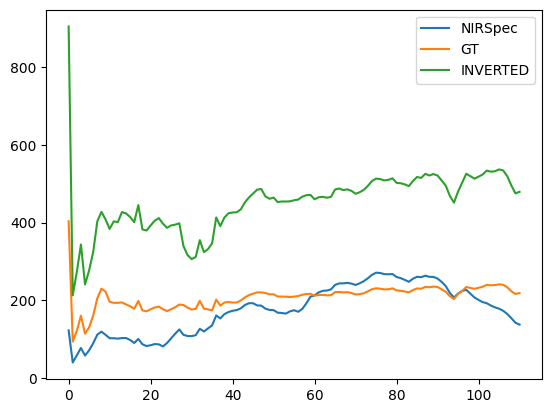

: 

In [ ]:
import matplotlib.pyplot as plt 

plt.plot(y_spectro.mean(axis=(1,2)), label="NIRSpec")
plt.plot(GT.mean(axis=(1,2)), label="GT")
plt.plot((y_spectro/L_pce_NIRSpec[...,np.newaxis,np.newaxis]).mean(axis=(1,2)), label="INVERTED")

plt.legend()
plt.show()

In [122]:
# MQM = Maps_Quality_Metrics_2(true_maps, L_specs)

# quadcriterion_test = QuadCriterion2(
#     mu_imager,
#     y_imager,
#     mirim_model_for_fusion,
#     mu_spectro,
#     y_spectro,
#     spectro_model,
#     0,
#     printing = False,
#     gradient = "separated"
# )

# # initial range of search
# list_of_mu = [100, 500]
# best_mse, best_mu = optimal_res_dicho_quad2(quadcriterion_test, MQM.get_mse, list_of_mu)

In [ ]:
best_mu = 120

quadcriterion = QuadCriterion2(
    mu_imager,
    y_imager,
    mirim_model_for_fusion,
    mu_spectro,
    y_spectro,
    spectro_model,
    best_mu,
    printing = False,
    gradient = "separated"
)

res = quadcriterion.run_lcg(maximum_iterations = 1000)
quadcrit_rec_maps = res.x

guilloteau_fused = return_mixture(L_specs, quadcrit_rec_maps.T)[:, margin//2:-margin//2, margin//2:-margin//2]
y_imager_plot = y_imager[:, margin//2:-margin//2, margin//2:-margin//2]
y_spectro_plot = y_spectro[:, (margin//2)//di:-(margin//2)//di, (margin//2)//dj:-(margin//2)//dj]

ValueError: operands could not be broadcast together with shapes (28,28,40,40) (5,40,40) 

: 

In [17]:
best_thresh = 1
best_mu = 0.057197265625

#%%

# check courbe de MSE

sq_criterion = SemiQuad_Criterion_Fusion(
    mu_imager,
    y_imager,
    mirim_model_for_fusion,
    mu_spectro,
    y_spectro,
    spectro_model,
    mu_reg = best_mu,
    thresh = best_thresh,
    printing = True,
    scale = 0.5
)

minimization = "iterative"
# minimization = "iterative_with_metric"

t1 = time.time()
if minimization == "iterative" :
    rec_maps_sq = sq_criterion.run_expsol(n_iter_max = 2000, diff_min = 1e-25, calc_crit = False)

quadcrit_rec_maps_Dan = rec_maps_sq.x

guilloteau_fused = return_mixture(L_specs, quadcrit_rec_maps_Dan.T)[:, margin//2:-margin//2, margin//2:-margin//2]

Huber threshold = 1
Parameter scale = 0.5


Reconstruction ended
Number of executed iterations : 39 (0.034 sec)
Total time needed = 0.058 + 0.034 = 0.092 sec.
Iterations ended due to :
Difference between iterated solutions < threshold (1e-25).


Careful: np.mean(rec_maps) < 1. Huber probably didn't work properly.


AttributeError: 'numpy.ndarray' object has no attribute 'x'